In [1]:
!pip install pytorch-ignite
!pip install torch-summary
!pip install ipywidgets

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import torch
import torchvision
import ignite

print(*map(lambda m: ": ".join((m.__name__, m.__version__)), (torch, torchvision, ignite)), sep="\n")

torch: 2.2.1+cu121
torchvision: 0.17.1+cu121
ignite: 0.5.2


In [3]:
import os
import logging
import matplotlib.pyplot as plt

import numpy as np

from torchsummary import summary

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.datasets import ImageFolder
from torchvision import datasets

from ignite.engine import Engine, Events
from ignite.metrics import FID, InceptionScore
import ignite.distributed as idist
from ignite.metrics import RunningAverage
from ignite.contrib.handlers import ProgressBar

import PIL.Image as Image

In [4]:
ignite.utils.manual_seed(999)
ignite.utils.setup_logger(name="ignite.distributed.auto.auto_dataloader", level=logging.WARNING)
ignite.utils.setup_logger(name="ignite.distributed.launcher.Parallel", level=logging.WARNING)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
# Root directory for dataset
dataroot = "data/cifar10"

# Number of workers for dataloader
WORKERS = 4

# Batch size during training
BATCH_SIZE = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
IMAGE_SIZE = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [6]:
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

full_dataset = datasets.CIFAR10(
    root=dataroot,
    train=True,
    download=True,
    transform=transform
)

train_dataset = torch.utils.data.Subset(full_dataset, torch.arange(7000))

test_dataset = torch.utils.data.Subset(full_dataset, torch.arange(7000, 10000))

Files already downloaded and verified


In [7]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=WORKERS,
    drop_last = True
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=WORKERS
)

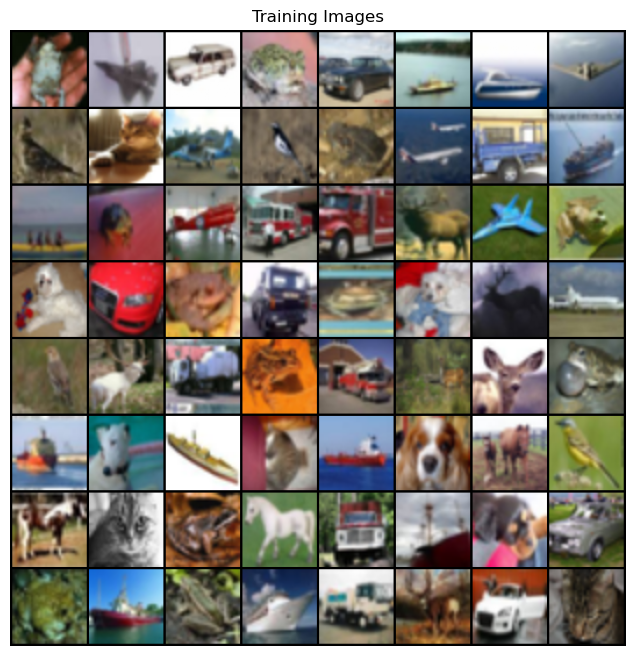

In [8]:
real_batch = next(iter(train_dataloader))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [9]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu, nz, ngf, nc):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [10]:
netG = idist.auto_model(Generator(ngpu, nz, ngf, nc))

idist.device()

summary(netG)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─ConvTranspose2d: 2-1              819,200
|    └─BatchNorm2d: 2-2                  1,024
|    └─ReLU: 2-3                         --
|    └─ConvTranspose2d: 2-4              2,097,152
|    └─BatchNorm2d: 2-5                  512
|    └─ReLU: 2-6                         --
|    └─ConvTranspose2d: 2-7              524,288
|    └─BatchNorm2d: 2-8                  256
|    └─ReLU: 2-9                         --
|    └─ConvTranspose2d: 2-10             131,072
|    └─BatchNorm2d: 2-11                 128
|    └─ReLU: 2-12                        --
|    └─ConvTranspose2d: 2-13             3,072
|    └─Tanh: 2-14                        --
Total params: 3,576,704
Trainable params: 3,576,704
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─ConvTranspose2d: 2-1              819,200
|    └─BatchNorm2d: 2-2                  1,024
|    └─ReLU: 2-3                         --
|    └─ConvTranspose2d: 2-4              2,097,152
|    └─BatchNorm2d: 2-5                  512
|    └─ReLU: 2-6                         --
|    └─ConvTranspose2d: 2-7              524,288
|    └─BatchNorm2d: 2-8                  256
|    └─ReLU: 2-9                         --
|    └─ConvTranspose2d: 2-10             131,072
|    └─BatchNorm2d: 2-11                 128
|    └─ReLU: 2-12                        --
|    └─ConvTranspose2d: 2-13             3,072
|    └─Tanh: 2-14                        --
Total params: 3,576,704
Trainable params: 3,576,704
Non-trainable params: 0

In [11]:
class Discriminator(nn.Module):
    def __init__(self, ndf, nc):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [12]:
netD = idist.auto_model(Discriminator(ndf, nc))
summary(netD)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       3,072
|    └─LeakyReLU: 2-2                    --
|    └─Conv2d: 2-3                       131,072
|    └─BatchNorm2d: 2-4                  256
|    └─LeakyReLU: 2-5                    --
|    └─Conv2d: 2-6                       524,288
|    └─BatchNorm2d: 2-7                  512
|    └─LeakyReLU: 2-8                    --
|    └─Conv2d: 2-9                       2,097,152
|    └─BatchNorm2d: 2-10                 1,024
|    └─LeakyReLU: 2-11                   --
|    └─Conv2d: 2-12                      8,192
|    └─Sigmoid: 2-13                     --
Total params: 2,765,568
Trainable params: 2,765,568
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       3,072
|    └─LeakyReLU: 2-2                    --
|    └─Conv2d: 2-3                       131,072
|    └─BatchNorm2d: 2-4                  256
|    └─LeakyReLU: 2-5                    --
|    └─Conv2d: 2-6                       524,288
|    └─BatchNorm2d: 2-7                  512
|    └─LeakyReLU: 2-8                    --
|    └─Conv2d: 2-9                       2,097,152
|    └─BatchNorm2d: 2-10                 1,024
|    └─LeakyReLU: 2-11                   --
|    └─Conv2d: 2-12                      8,192
|    └─Sigmoid: 2-13                     --
Total params: 2,765,568
Trainable params: 2,765,568
Non-trainable params: 0

In [13]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=idist.device())

optimizerD = idist.auto_optim(
    optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
)

optimizerG = idist.auto_optim(
    optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
)

In [14]:
real_label = 1
fake_label = 0


def training_step(engine, data):
    # Set the models for training
    netG.train()
    netD.train()

    ############################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ###########################
    ## Train with all-real batch
    netD.zero_grad()
    # Format batch
    real = data[0].to(idist.device())
    b_size = real.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device=idist.device())
    # Forward pass real batch through D
    output1 = netD(real).view(-1)
    # Calculate loss on all-real batch
    errD_real = criterion(output1, label)
    # Calculate gradients for D in backward pass
    errD_real.backward()

    ## Train with all-fake batch
    # Generate batch of latent vectors
    noise = torch.randn(b_size, nz, 1, 1, device=idist.device())
    # Generate fake image batch with G
    fake = netG(noise)
    label.fill_(fake_label)
    # Classify all fake batch with D
    output2 = netD(fake.detach()).view(-1)
    # Calculate D's loss on the all-fake batch
    errD_fake = criterion(output2, label)
    # Calculate the gradients for this batch, accumulated (summed) with previous gradients
    errD_fake.backward()
    # Compute error of D as sum over the fake and the real batches
    errD = errD_real + errD_fake
    # Update D
    optimizerD.step()

    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    netG.zero_grad()
    label.fill_(real_label)  # fake labels are real for generator cost
    # Since we just updated D, perform another forward pass of all-fake batch through D
    output3 = netD(fake).view(-1)
    # Calculate G's loss based on this output
    errG = criterion(output3, label)
    # Calculate gradients for G
    errG.backward()
    # Update G
    optimizerG.step()

    return {
        "Loss_G" : errG.item(),
        "Loss_D" : errD.item(),
        "D_x": output1.mean().item(),
        "D_G_z1": output2.mean().item(),
        "D_G_z2": output3.mean().item(),
    }

In [15]:
trainer = Engine(training_step)

In [16]:
def initialize_fn(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [17]:
@trainer.on(Events.STARTED)
def init_weights():
    netD.apply(initialize_fn)
    netG.apply(initialize_fn)

In [18]:
G_losses = []
D_losses = []


@trainer.on(Events.ITERATION_COMPLETED)
def store_losses(engine):
    o = engine.state.output
    G_losses.append(o["Loss_G"])
    D_losses.append(o["Loss_D"])

In [19]:
img_list = []

@trainer.on(Events.ITERATION_COMPLETED(every=500))
def store_images(engine):
    with torch.no_grad():
        fake = netG(fixed_noise).cpu()
    img_list.append(fake)

In [20]:
#fid_metric = FID(device=idist.device())
#is_metric = InceptionScore(device=idist.device(), output_transform=lambda x: x[0])

In [21]:
"""
def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = transforms.ToPILImage()(img)
        resized_img = pil_img.resize((299,299), Image.BILINEAR)
        arr.append(transforms.ToTensor()(resized_img))
    return torch.stack(arr)


def evaluation_step(engine, batch):
    with torch.no_grad():
        noise = torch.randn(BATCH_SIZE, nz, 1, 1, device=idist.device())
        netG.eval()
        fake_batch = netG(noise)
        fake = interpolate(fake_batch)
        real = interpolate(batch[0])
        return fake, real
"""

'\ndef interpolate(batch):\n    arr = []\n    for img in batch:\n        pil_img = transforms.ToPILImage()(img)\n        resized_img = pil_img.resize((299,299), Image.BILINEAR)\n        arr.append(transforms.ToTensor()(resized_img))\n    return torch.stack(arr)\n\n\ndef evaluation_step(engine, batch):\n    with torch.no_grad():\n        noise = torch.randn(BATCH_SIZE, nz, 1, 1, device=idist.device())\n        netG.eval()\n        fake_batch = netG(noise)\n        fake = interpolate(fake_batch)\n        real = interpolate(batch[0])\n        return fake, real\n'

In [22]:
#evaluator = Engine(evaluation_step)
#fid_metric.attach(evaluator, "fid")
#is_metric.attach(evaluator, "is")

In [23]:
"""
fid_values = []
is_values = []


@trainer.on(Events.COMPLETED)
def log_training_results(engine):
    evaluator.run(test_dataloader,max_epochs=1)
    metrics = evaluator.state.metrics
    fid_score = metrics['fid']
    is_score = metrics['is']
    fid_values.append(fid_score)
    is_values.append(is_score)
    print(f"Epoch [{engine.state.epoch}/{num_epochs}] Metric Scores")
    print(f"*   FID : {fid_score:4f}")
    print(f"*    IS : {is_score:4f}")
"""

'\nfid_values = []\nis_values = []\n\n\n@trainer.on(Events.COMPLETED)\ndef log_training_results(engine):\n    evaluator.run(test_dataloader,max_epochs=1)\n    metrics = evaluator.state.metrics\n    fid_score = metrics[\'fid\']\n    is_score = metrics[\'is\']\n    fid_values.append(fid_score)\n    is_values.append(is_score)\n    print(f"Epoch [{engine.state.epoch}/{num_epochs}] Metric Scores")\n    print(f"*   FID : {fid_score:4f}")\n    print(f"*    IS : {is_score:4f}")\n'

In [24]:
RunningAverage(output_transform=lambda x: x["Loss_G"]).attach(trainer, 'Loss_G')
RunningAverage(output_transform=lambda x: x["Loss_D"]).attach(trainer, 'Loss_D')

In [25]:
ProgressBar().attach(trainer, metric_names=['Loss_G','Loss_D'])
#ProgressBar().attach(evaluator)

In [26]:
def training(*args):
    trainer.run(train_dataloader, max_epochs=num_epochs)

In [27]:
with idist.Parallel(backend='nccl') as parallel:
    parallel.run(training)

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

[1/54]   2%|1          [00:00<?]

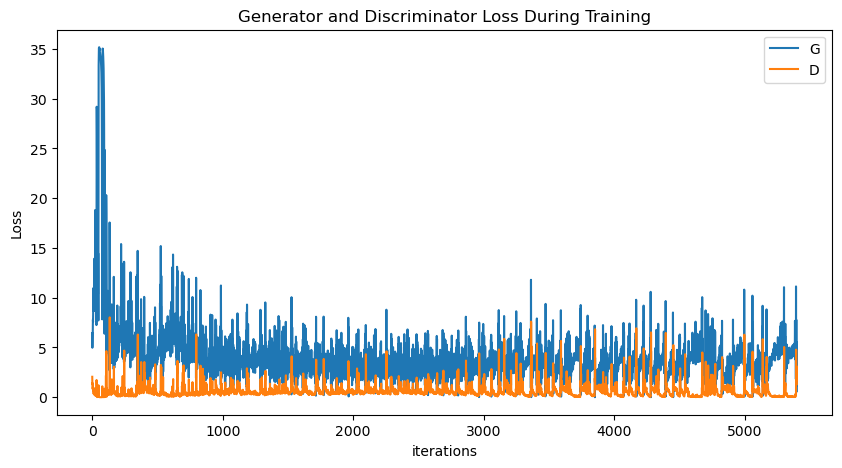

In [28]:
%matplotlib inline

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

In [29]:
"""
fig, ax1 = plt.subplots()

plt.title("Evaluation Metric During Training")

color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('IS', color=color)
ax1.plot(is_values, color=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('FID', color=color)
ax2.plot(fid_values, color=color)

fig.tight_layout()
"""

'\nfig, ax1 = plt.subplots()\n\nplt.title("Evaluation Metric During Training")\n\ncolor = \'tab:red\'\nax1.set_xlabel(\'epochs\')\nax1.set_ylabel(\'IS\', color=color)\nax1.plot(is_values, color=color)\n\nax2 = ax1.twinx()\n\ncolor = \'tab:blue\'\nax2.set_ylabel(\'FID\', color=color)\nax2.plot(fid_values, color=color)\n\nfig.tight_layout()\n'

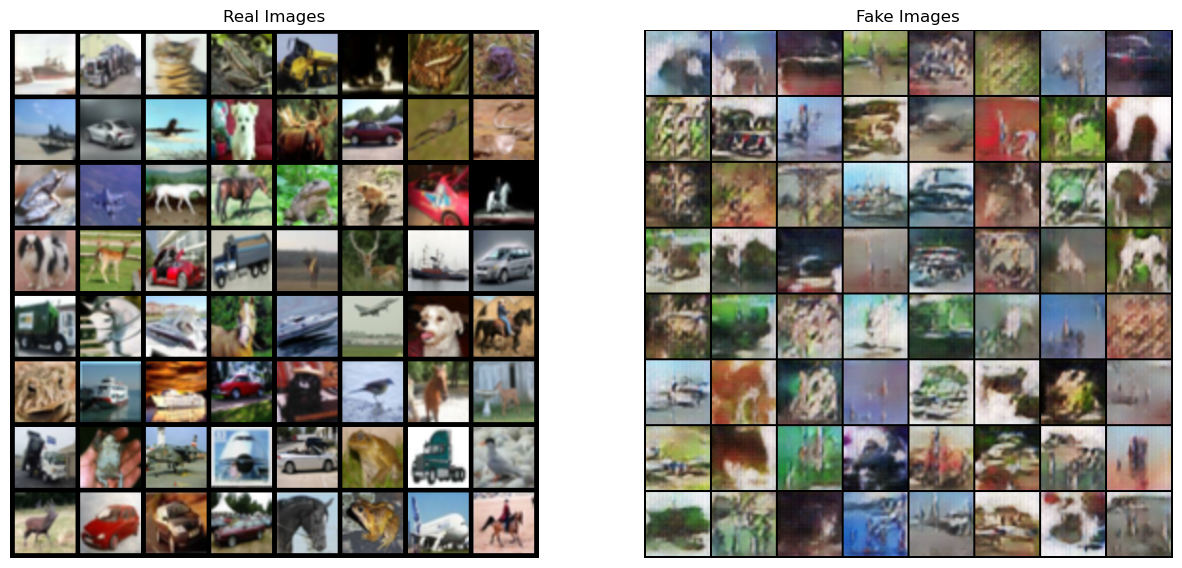

In [30]:
%matplotlib inline

# Grab a batch of real images from the dataloader
real_batch = next(iter(train_dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(img_list[-1], padding=2, normalize=True).cpu(),(1,2,0)))